In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import joblib
from IPython.display import Audio, display
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [5]:
import pymysql
import os
from dotenv import load_dotenv

def connect_to_db():
    """Kết nối đến cơ sở dữ liệu từ biến môi trường"""
    load_dotenv()
    
    conn = pymysql.connect(
        host=os.getenv('DB_HOST'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD'),
        database=os.getenv('DB_NAME')
    )
    return conn, conn.cursor()


In [7]:
def create_tables():
    """Tạo các bảng cần thiết trong cơ sở dữ liệu"""
    conn, cursor = connect_to_db()
    
    # Xóa các bảng cũ nếu đã tồn tại
    cursor.execute("DROP TABLE IF EXISTS voice_mfcc_normalized")
    cursor.execute("DROP TABLE IF EXISTS voice_features_normalized")
    cursor.execute("DROP TABLE IF EXISTS voice_mfcc")
    cursor.execute("DROP TABLE IF EXISTS voice_features")
    conn.commit()
    
    # Tạo bảng voice với tất cả các đặc trưng và hệ số MFCC
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS voice (
        id INT AUTO_INCREMENT PRIMARY KEY,
        filename VARCHAR(255) NOT NULL,
        pitch FLOAT,
        energy FLOAT,
        zcr FLOAT,
        centroid FLOAT,
        mfcc_1 FLOAT,
        mfcc_2 FLOAT,
        mfcc_3 FLOAT,
        mfcc_4 FLOAT,
        mfcc_5 FLOAT,
        mfcc_6 FLOAT,
        mfcc_7 FLOAT,
        mfcc_8 FLOAT,
        mfcc_9 FLOAT,
        mfcc_10 FLOAT,
        mfcc_11 FLOAT,
        mfcc_12 FLOAT,
        mfcc_13 FLOAT
    )
    """)
    
    # Tạo bảng voice_normalized với các đặc trưng đã chuẩn hóa
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS voice_normalized (
        id INT AUTO_INCREMENT PRIMARY KEY,
        filename VARCHAR(255) NOT NULL,
        pitch FLOAT,
        energy FLOAT,
        zcr FLOAT,
        centroid FLOAT,
        mfcc_1 FLOAT,
        mfcc_2 FLOAT,
        mfcc_3 FLOAT,
        mfcc_4 FLOAT,
        mfcc_5 FLOAT,
        mfcc_6 FLOAT,
        mfcc_7 FLOAT,
        mfcc_8 FLOAT,
        mfcc_9 FLOAT,
        mfcc_10 FLOAT,
        mfcc_11 FLOAT,
        mfcc_12 FLOAT,
        mfcc_13 FLOAT
    )
    """)
    
    conn.commit()
    conn.close()
    
    print("Đã tạo các bảng mới trong cơ sở dữ liệu: voice và voice_normalized")

# Tạo bảng mới
create_tables()

Đã tạo các bảng mới trong cơ sở dữ liệu: voice và voice_normalized


In [8]:
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    y = librosa.util.fix_length(y, size=5 * sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch, mag = librosa.piptrack(y=y, sr=sr)
    pitches = pitch[mag > np.median(mag)]
    pitch_mean = np.mean(pitches) if len(pitches) > 0 else 0

    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    energy = np.mean(y ** 2)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    return {
        "mfcc": np.mean(mfcc, axis=1).tolist(),
        "pitch": float(pitch_mean),
        "energy": float(energy),
        "zcr": float(zcr),
        "centroid": float(centroid)
    }

In [10]:
from sklearn.preprocessing import MinMaxScaler


def save_features_to_mysql(folder_path):
    """Lưu đặc trưng của các file âm thanh vào cơ sở dữ liệu MySQL"""
    conn, cursor = connect_to_db()
    data = []
    
    # Xóa dữ liệu cũ trước khi thêm mới
    cursor.execute("DELETE FROM voice")
    cursor.execute("DELETE FROM voice_normalized")
    conn.commit()
    
    # Đọc và tích trắc đặc trưng của các file âm thanh
    for file in glob(os.path.join(folder_path, "*.wav")):
        features = extract_audio_features(file)
        row = {
            "filename": os.path.basename(file),
            "pitch": features["pitch"],
            "energy": features["energy"],
            "zcr": features["zcr"],
            "centroid": features["centroid"]
        }
        
        # Thêm các hệ số MFCC vào row
        for i, mfcc_val in enumerate(features["mfcc"]):
            row[f"mfcc_{i+1}"] = float(mfcc_val)
            
        data.append(row)
    
    # Lưu đặc trưng vào bảng voice
    for item in data:
        cursor.execute("""
        INSERT INTO voice (filename, pitch, energy, zcr, centroid, 
                        mfcc_1, mfcc_2, mfcc_3, mfcc_4, mfcc_5, mfcc_6, mfcc_7,
                        mfcc_8, mfcc_9, mfcc_10, mfcc_11, mfcc_12, mfcc_13)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, (
            item["filename"], item["pitch"], item["energy"], item["zcr"], item["centroid"],
            item["mfcc_1"], item["mfcc_2"], item["mfcc_3"], item["mfcc_4"], item["mfcc_5"],
            item["mfcc_6"], item["mfcc_7"], item["mfcc_8"], item["mfcc_9"], item["mfcc_10"],
            item["mfcc_11"], item["mfcc_12"], item["mfcc_13"]
        ))
        
    conn.commit()
    print(f" Đã lưu đặc trưng vào cơ sở dữ liệu")
    # Tạo DataFrame để hiển thị và chuẩn hóa
    df = pd.DataFrame(data)
    display(df.head(10))
    
    if len(df) > 0:
        # Chuẩn hóa dữ liệu theo min-max với phạm vi [-1, 1]
        feature_cols = [col for col in df.columns if col != "filename"]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df_scaled = df.copy()
        df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])
        
        # Lưu scaler để sử dụng sau này
        joblib.dump(scaler, "scaler.pkl")
        print(" Đã lưu scaler.pkl")
        
        # Lưu dữ liệu chuẩn hóa vào bảng voice_normalized
        for _, row in df_scaled.iterrows():
            cursor.execute("""
            INSERT INTO voice_normalized (filename, pitch, energy, zcr, centroid, 
                                        mfcc_1, mfcc_2, mfcc_3, mfcc_4, mfcc_5, mfcc_6, mfcc_7,
                                        mfcc_8, mfcc_9, mfcc_10, mfcc_11, mfcc_12, mfcc_13)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """, (
                row["filename"], row["pitch"], row["energy"], row["zcr"], row["centroid"],
                row["mfcc_1"], row["mfcc_2"], row["mfcc_3"], row["mfcc_4"], row["mfcc_5"],
                row["mfcc_6"], row["mfcc_7"], row["mfcc_8"], row["mfcc_9"], row["mfcc_10"],
                row["mfcc_11"], row["mfcc_12"], row["mfcc_13"]
            ))
        
        conn.commit()
        print(" Đã lưu dữ liệu chuẩn hóa vào cơ sở dữ liệu")
    else:
        print(" Không có dữ liệu để chuẩn hóa.")
    
    conn.close()

def check_and_save_audio_features(audio_path):
    """Kiểm tra xem file âm thanh đã được trích xuất và lưu vào cơ sở dữ liệu chưa, nếu chưa thì trích xuất và lưu"""
    conn, cursor = connect_to_db()
    filename = os.path.basename(audio_path)
    
    # Kiểm tra xem file đã tồn tại trong database chưa
    cursor.execute("SELECT id FROM voice WHERE filename = %s", (filename,))
    result = cursor.fetchone()
    
    if result:
        print(f"File {filename} đã có trong cơ sở dữ liệu")
        conn.close()
        return True
    else:
        print(f"File {filename} chưa có trong cơ sở dữ liệu, đang trích xuất và lưu...")
        
        # Trích xuất đặc trưng của file
        features = extract_audio_features(audio_path)
        
        # Tạo dữ liệu để chèn vào database
        feature_values = [
            filename, features["pitch"], features["energy"], features["zcr"], features["centroid"]
        ]
        
        # Thêm các hệ số MFCC
        for val in features["mfcc"]:
            feature_values.append(float(val))
        
        # Tạo dữ liệu để chèn vào database
        feature_values = [
            filename, features["pitch"], features["energy"], features["zcr"], features["centroid"]
        ]
        
        # Thêm các hệ số MFCC
        for val in features["mfcc"]:
            feature_values.append(float(val))
        
        # Chèn vào cơ sở dữ liệu
        cursor.execute("""
        INSERT INTO voice (filename, pitch, energy, zcr, centroid, 
                        mfcc_1, mfcc_2, mfcc_3, mfcc_4, mfcc_5, mfcc_6, mfcc_7,
                        mfcc_8, mfcc_9, mfcc_10, mfcc_11, mfcc_12, mfcc_13)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, tuple(feature_values))
        
        # Cũng cần cập nhật bảng chuẩn hóa
        # Nạp scaler đã được lưu trước đó
        try:
            scaler = joblib.load("scaler.pkl")
            
            # Chuẩn hóa đặc trưng với scaler đã có
            feature_vector = [features["pitch"], features["energy"], features["zcr"], features["centroid"]] + features["mfcc"]
            normalized_features = scaler.transform([feature_vector])[0]
            
            # Tạo dữ liệu để chèn vào bảng chuẩn hóa
            normalized_values = [filename] + list(normalized_features)
            
            # Chèn vào bảng chuẩn hóa
            cursor.execute("""
            INSERT INTO voice_normalized (filename, pitch, energy, zcr, centroid, 
                                        mfcc_1, mfcc_2, mfcc_3, mfcc_4, mfcc_5, mfcc_6, mfcc_7,
                                        mfcc_8, mfcc_9, mfcc_10, mfcc_11, mfcc_12, mfcc_13)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """, tuple(normalized_values))
            
            print(f"Lưu đặc trưng chuẩn hóa thành công cho file {filename}")
        except (FileNotFoundError, KeyError) as e:
            print(f"Không thể lưu đặc trưng chuẩn hóa: {e}. Hãy chạy hàm save_features_to_mysql trước ")
        
        conn.commit()
        conn.close()
        print(f"Lưu thành công đặc trưng cho file {filename}")
        return True

In [11]:
folder_path = "data"

# Gọi hàm lưu đặc trưng vào MySQL
save_features_to_mysql(folder_path)


 Đã lưu đặc trưng vào cơ sở dữ liệu


,filename,pitch,energy,zcr,centroid,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,common_voice_vi_21833241.wav,1509.253418,0.001653,0.132467,1110.619048,-454.999542,38.230663,0.856070,14.537650,7.123565,-0.007519,2.774929,-0.207051,-3.040796,-1.645425,-0.579669,-2.131577,-3.401818
1,common_voice_vi_22416752.wav,1683.839478,0.003487,0.108168,1344.184091,-443.903168,33.641331,-13.285260,15.391407,0.970643,-5.154279,-3.642655,-9.131556,-4.704126,-5.934633,-6.067626,-2.948416,-7.037601
2,common_voice_vi_22770199.wav,1003.127930,0.002518,0.040841,591.551052,-470.846741,76.914406,11.289367,13.408834,7.498422,3.486368,-7.352954,2.745964,-5.834911,-0.340338,-0.718981,-7.979136,1.459484
3,common_voice_vi_23078482.wav,932.708618,0.000125,0.115384,1579.414532,-545.150513,57.743114,14.553512,15.085620,9.194815,-6.545613,-6.116631,-8.800157,-3.419756,-14.036370,-7.495000,-8.114399,-3.289852
4,common_voice_vi_23078577.wav,833.923401,0.000057,0.083922,1213.362081,-597.279114,53.060932,7.634211,2.571421,4.293199,-4.874186,-2.912720,-7.178341,-2.726200,-8.265352,-5.295058,-9.122911,-3.465223
5,common_voice_vi_23423355.wav,430.872589,0.001987,0.031427,664.537554,-478.156860,69.430496,15.745341,8.760016,4.631933,1.412203,-3.467169,-6.190527,-2.750938,-1.615876,-2.743089,-3.528254,-2.875460
6,common_voice_vi_23423374.wav,823.517334,0.003414,0.050931,760.479759,-418.428284,100.016632,0.720437,0.778276,-0.290115,2.236181,-7.016133,-5.411560,0.861940,-1.291407,-6.251036,-5.826214,-2.095643
7,common_voice_vi_23755975.wav,1343.218628,0.010239,0.115265,1701.118791,-307.694214,73.225906,3.666894,16.461643,-10.809363,2.482480,-18.513145,-10.190249,-22.740215,-16.747831,-13.425338,-11.105086,-15.261907
8,common_voice_vi_23848857.wav,1246.303711,0.000288,0.095143,1335.602598,-529.698303,59.371212,-8.038399,20.108580,1.871128,-14.126921,-12.036981,-11.212379,-2.829467,-8.795442,-12.675596,-7.419306,-8.712232
9,common_voice_vi_23925103.wav,1245.651978,0.003236,0.081810,1029.098051,-440.022827,76.094978,-6.788183,22.109612,-2.944340,-3.575470,-11.216825,-8.519381,0.239556,-5.973655,-9.518149,-2.180172,-4.437620


 Đã lưu scaler.pkl
 Đã lưu dữ liệu chuẩn hóa vào cơ sở dữ liệu


In [18]:
# Kiểm tra và lưu đặc trưng của một file âm thanh cụ thể
input_audio = os.getenv('INPUT_AUDIO')


check_and_save_audio_features(input_audio)

# Nếu muốn kiểm tra và lưu nhiều file
# for file in glob("*.wav"):
#     check_and_save_audio_features(file)

File common_voice_vi_21833241.wav đã có trong cơ sở dữ liệu


True

In [19]:
def find_nearest_audio(input_audio, scaler_path="scaler.pkl", top_k=3, distance_metric="Euclidean"):
    """
    Tìm các file âm thanh gần nhất với file đầu vào từ CSDL MySQL
    
    Parameters:
    -----------
    input_audio : str
        Đường dẫn đến file âm thanh đầu vào
    scaler_path : str
        Đường dẫn đến file scaler đã lưu
    top_k : int
        Số lượng file gần nhất cần trả về
    distance_metric : str
        Loại khoảng cách: "Euclidean", "Cosine" hoặc "Manhattan"
    
    Returns:
    --------
    list
        Danh sách các tuple chứa tên file và khoảng cách
    """
    # Kết nối tới cơ sở dữ liệu
    conn, cursor = connect_to_db()
    
    # Trích xuất đặc trưng của file âm thanh đầu vào
    features = extract_audio_features(input_audio)
    input_features = [features["pitch"], features["energy"], features["zcr"], features["centroid"]] + features["mfcc"]

    # Nạp scaler đã lưu và chuẩn hóa dữ liệu đầu vào
    try:
        scaler = joblib.load(scaler_path)
        input_scaled = scaler.transform([input_features])
        
        # Lấy dữ liệu đặc trưng chuẩn hóa từ cơ sở dữ liệu
        cursor.execute("""
        SELECT filename, pitch, energy, zcr, centroid, 
               mfcc_1, mfcc_2, mfcc_3, mfcc_4, mfcc_5, mfcc_6, mfcc_7,
               mfcc_8, mfcc_9, mfcc_10, mfcc_11, mfcc_12, mfcc_13
        FROM voice_normalized
        """)
        
        features_data = cursor.fetchall()
        if not features_data:
            conn.close()
            return []
        
        feature_vectors = []
        filenames = []
        
        # Xử lý từng mẫu đặc trưng trong cơ sở dữ liệu
        for feat in features_data:
            filenames.append(feat[0])
            
            # Lấy tất cả các giá trị đặc trưng
            all_features = list(feat[1:])  # pitch, energy, zcr, centroid, mfcc_1, mfcc_2, ...
            feature_vectors.append(all_features)
        
        conn.close()
        
        # Chuyển về định dạng numpy array để tính toán nhanh hơn
        feature_vectors = np.array(feature_vectors)
        
        # Tính khoảng cách dựa trên metric được chọn
        if distance_metric == "Euclidean":
            distances = euclidean_distances(input_scaled, feature_vectors)[0]
        elif distance_metric == "Cosine":
            distances = 1 - cosine_similarity(input_scaled, feature_vectors)[0]
        elif distance_metric == "Manhattan":
            from sklearn.metrics.pairwise import manhattan_distances
            distances = manhattan_distances(input_scaled, feature_vectors)[0]
        else:
            # Mặc định dùng Euclidean
            distances = euclidean_distances(input_scaled, feature_vectors)[0]

        # Tìm các file gần nhất
        nearest_indices = np.argsort(distances)[:top_k]
        nearest_files = [(filenames[i], distances[i]) for i in nearest_indices]

        return nearest_files
        
    except Exception as e:
        print(f"Lỗi khi tìm kiếm file tương đồng: {e}")
        conn.close()
        return []

In [20]:
input_audio_path = os.getenv('INPUT_AUDIO')

nearest = find_nearest_audio(input_audio_path)
print(nearest)
print("🔊 Input audio:")
display(Audio(input_audio_path, rate=16000))

print("\n🔍 3 file gần nhất:")
for filename, dist in nearest:
    print(f"📁 {filename} (distance: {dist:})")
    # display(Audio(os.path.join("data", filename), rate=16000))




[('common_voice_vi_21833241.wav', np.float64(8.880892053694331e-07)), ('common_voice_vi_24362986.wav', np.float64(0.8285436067594301)), ('common_voice_vi_24162852.wav', np.float64(1.0552873926367323))]
🔊 Input audio:


c:\Users\MyPc\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



🔍 3 file gần nhất:
📁 common_voice_vi_21833241.wav (distance: 8.880892053694331e-07)
📁 common_voice_vi_24362986.wav (distance: 0.8285436067594301)
📁 common_voice_vi_24162852.wav (distance: 1.0552873926367323)


In [23]:
os.makedirs("output", exist_ok=True)

for i, (filename, dist) in enumerate(nearest):
    output_path = os.path.join("output", filename)
    input_path = os.path.join("data", filename)
    shutil.copy(input_path, output_path)
    print(f"Đã sao chép {filename} vào thư mục 'output'")


Đã sao chép common_voice_vi_21833241.wav vào thư mục 'output'
Đã sao chép common_voice_vi_24362986.wav vào thư mục 'output'
Đã sao chép common_voice_vi_24162852.wav vào thư mục 'output'


c:\Users\MyPc\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


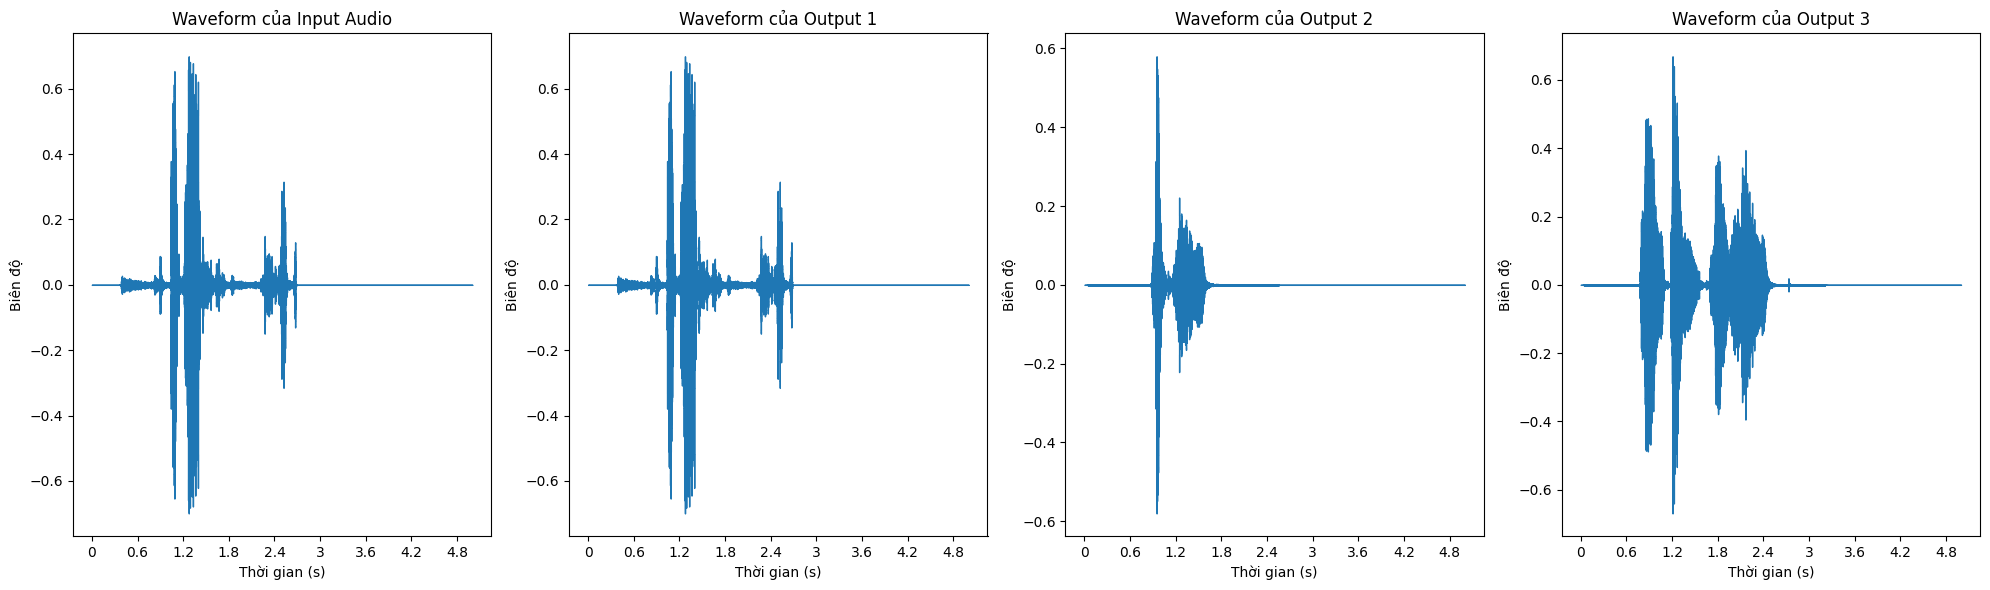

In [25]:
import librosa.display

input_audio_path = os.getenv('INPUT_AUDIO')
y_input, sr_input = librosa.load(input_audio_path, sr=16000)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

librosa.display.waveshow(y_input, sr=sr_input, ax=axes[0])
axes[0].set_title("Waveform của Input Audio")
axes[0].set_xlabel("Thời gian (s)")
axes[0].set_ylabel("Biên độ")

nearest = find_nearest_audio(input_audio_path)
output_files = [os.path.join("output", filename) for filename, _ in nearest]

for i, output_file in enumerate(output_files):
    y_output, sr_output = librosa.load(output_file, sr=16000)
    librosa.display.waveshow(y_output, sr=sr_output, ax=axes[i+1])
    axes[i+1].set_title(f"Waveform của Output {i+1}")
    axes[i+1].set_xlabel("Thời gian (s)")
    axes[i+1].set_ylabel("Biên độ")

plt.tight_layout()
plt.show()


c:\Users\MyPc\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


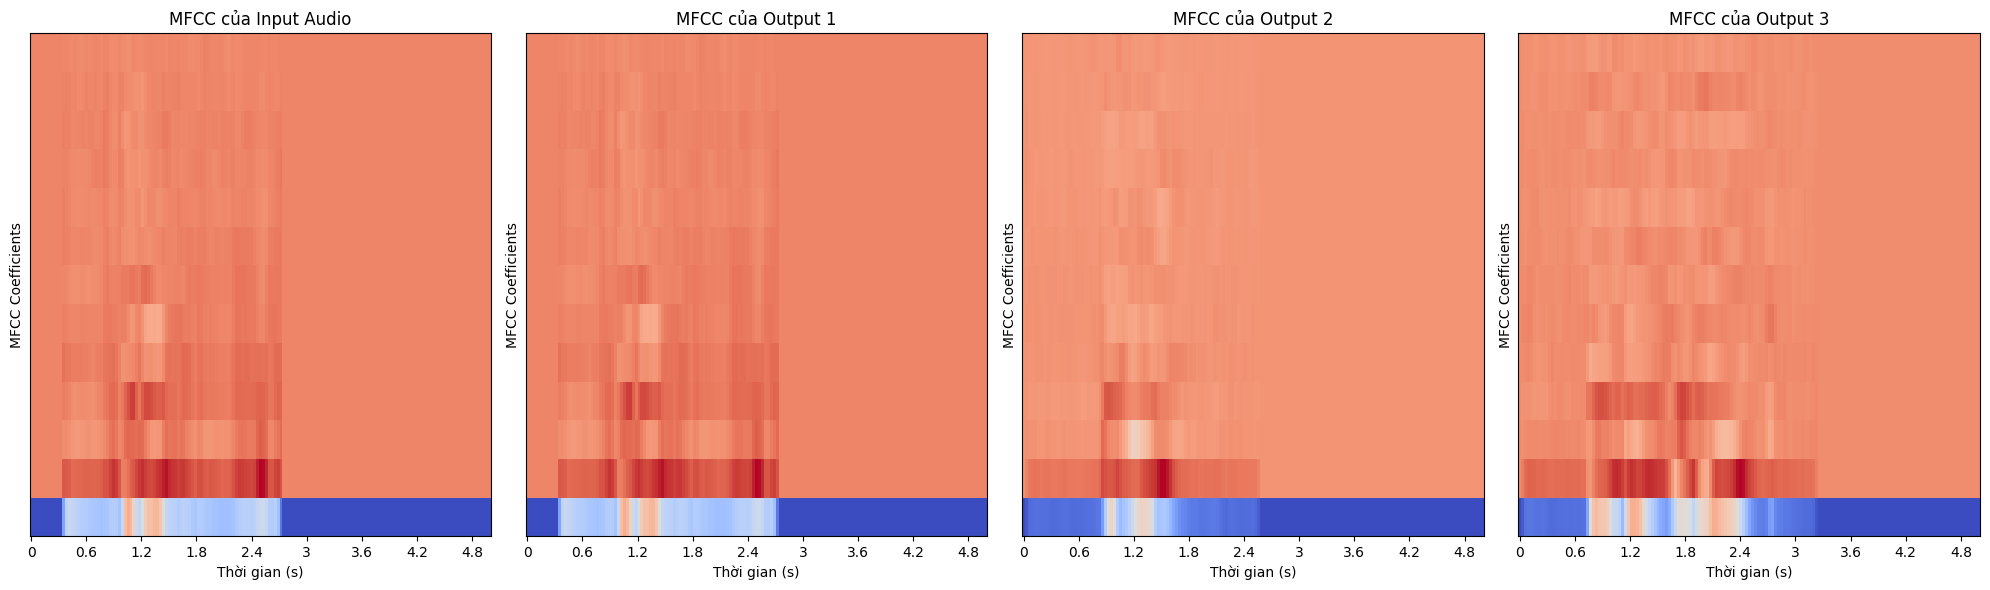

In [27]:
import librosa.display

input_audio_path = os.getenv('INPUT_AUDIO')
y_input, sr_input = librosa.load(input_audio_path, sr=16000)

mfcc_input = librosa.feature.mfcc(y=y_input, sr=sr_input, n_mfcc=13)

nearest = find_nearest_audio(input_audio_path)
output_files = [os.path.join("output", filename) for filename, _ in nearest]

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

librosa.display.specshow(mfcc_input, x_axis='time', sr=sr_input, ax=axes[0])
axes[0].set_title("MFCC của Input Audio")
axes[0].set_xlabel("Thời gian (s)")
axes[0].set_ylabel("MFCC Coefficients")

for i, output_file in enumerate(output_files):
    y_output, sr_output = librosa.load(output_file, sr=16000)
    mfcc_output = librosa.feature.mfcc(y=y_output, sr=sr_output, n_mfcc=13)
    
    librosa.display.specshow(mfcc_output, x_axis='time', sr=sr_output, ax=axes[i+1])
    axes[i+1].set_title(f"MFCC của Output {i+1}")
    axes[i+1].set_xlabel("Thời gian (s)")
    axes[i+1].set_ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()


C:\Users\MyPc\AppData\Local\Temp\ipykernel_16320\2424361183.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_input = librosa.amplitude_to_db(librosa.stft(y_input), ref=np.max)
c:\Users\MyPc\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\MyPc\AppData\Local\Temp\ipykernel_16320\2424361183.py:20: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_output = librosa.amplitude_to_db(librosa.stft(y_output), ref=np.max)


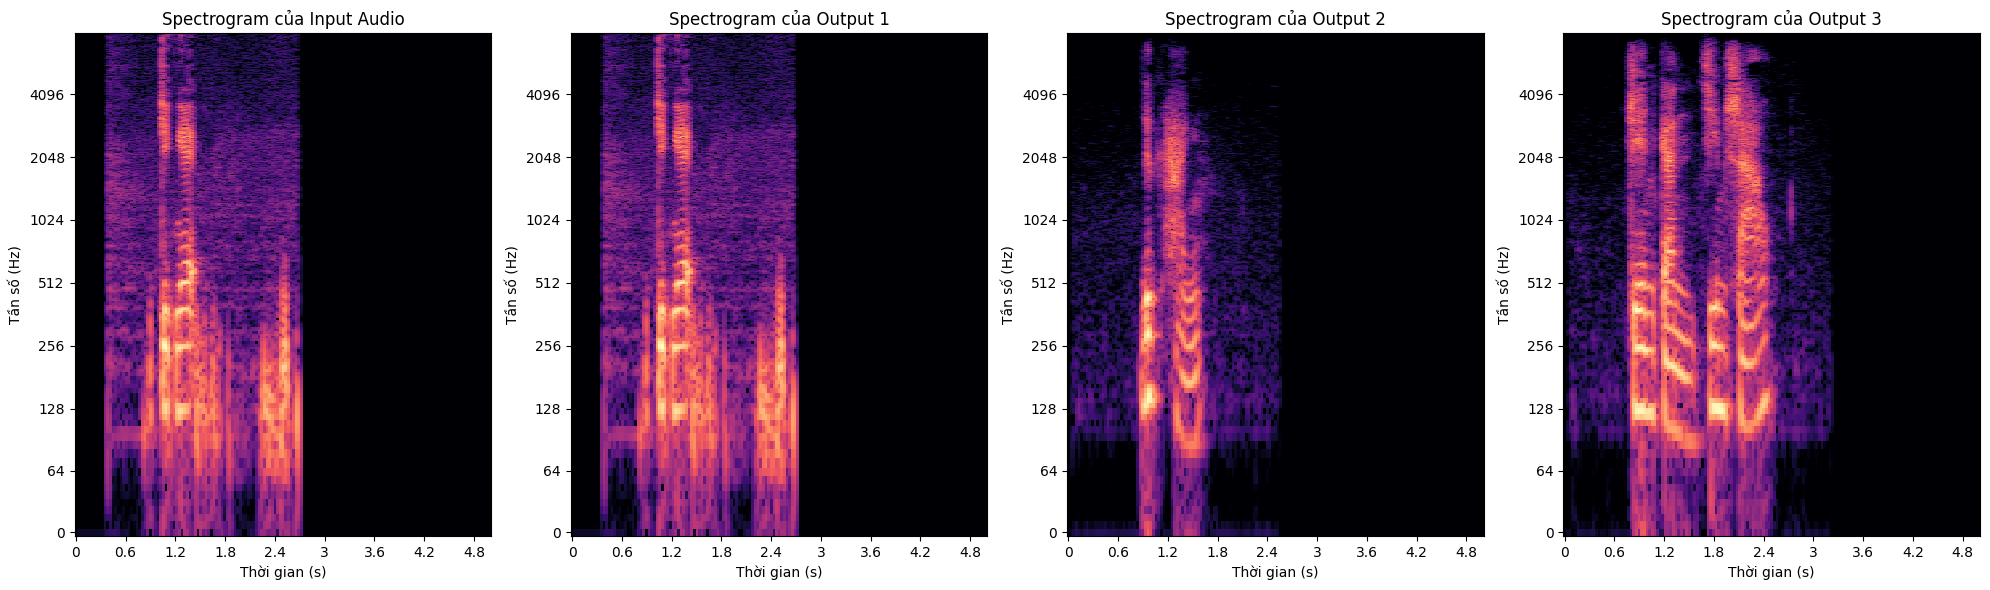

In [28]:
import librosa.display

input_audio_path = os.getenv('INPUT_AUDIO')
y_input, sr_input = librosa.load(input_audio_path, sr=16000)

D_input = librosa.amplitude_to_db(librosa.stft(y_input), ref=np.max)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

librosa.display.specshow(D_input, x_axis='time', y_axis='log', sr=sr_input, ax=axes[0])
axes[0].set_title("Spectrogram của Input Audio")
axes[0].set_xlabel("Thời gian (s)")
axes[0].set_ylabel("Tần số (Hz)")

nearest = find_nearest_audio(input_audio_path)
output_files = [os.path.join("output", filename) for filename, _ in nearest]

for i, output_file in enumerate(output_files):
    y_output, sr_output = librosa.load(output_file, sr=16000)
    D_output = librosa.amplitude_to_db(librosa.stft(y_output), ref=np.max)
    
    librosa.display.specshow(D_output, x_axis='time', y_axis='log', sr=sr_output, ax=axes[i+1])
    axes[i+1].set_title(f"Spectrogram của Output {i+1}")
    axes[i+1].set_xlabel("Thời gian (s)")
    axes[i+1].set_ylabel("Tần số (Hz)")

plt.tight_layout()
plt.show()


c:\Users\MyPc\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


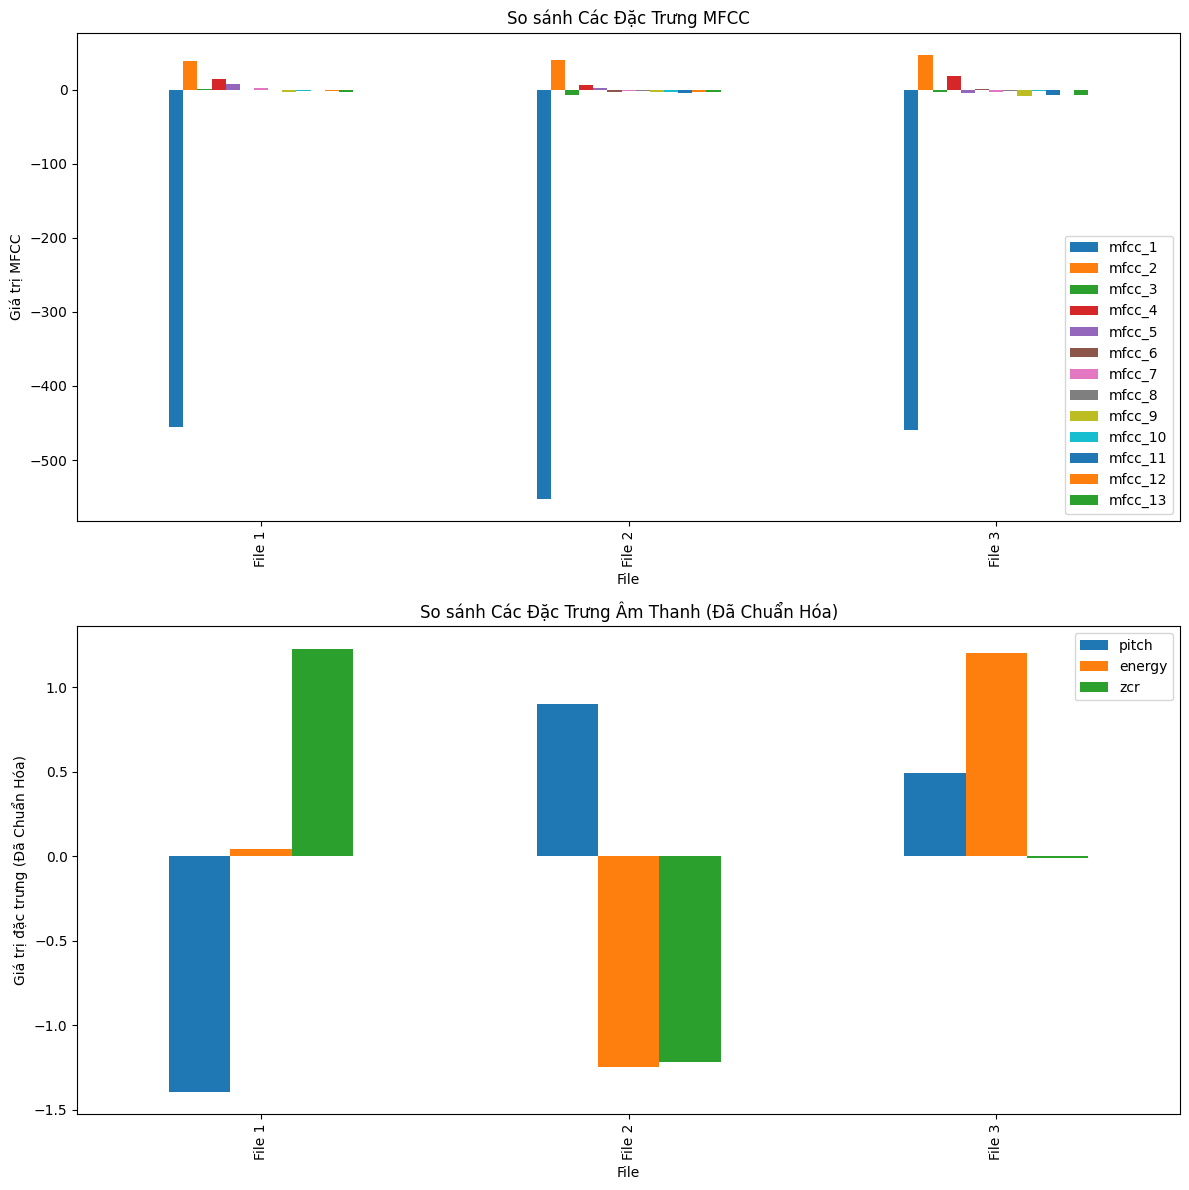

In [29]:
# Hàm lấy đặc trưng từ cơ sở dữ liệu
def get_features_from_mysql(filenames):
    conn, cursor = connect_to_db()
    features = []
    mfcc_features = []
    
    for filename in filenames:
        # Tìm kiếm đặc trưng từ bảng voice mới
        cursor.execute("""
        SELECT pitch, energy, zcr, centroid, 
               mfcc_1, mfcc_2, mfcc_3, mfcc_4, mfcc_5, mfcc_6, mfcc_7,
               mfcc_8, mfcc_9, mfcc_10, mfcc_11, mfcc_12, mfcc_13
        FROM voice
        WHERE filename = %s
        """, (filename,))
        
        result = cursor.fetchone()
        if result:
            # Thêm đặc trưng cơ bản vào danh sách
            features.append({
                "pitch": result[0],
                "energy": result[1],
                "zcr": result[2]
            })
            
            # Lấy các hệ số MFCC
            mfcc = list(result[4:])
            mfcc_features.append(mfcc)
    
    conn.close()
    return features, mfcc_features

# Lấy danh sách file gần nhất
nearest = find_nearest_audio(input_audio_path)
filenames = [filename for filename, _ in nearest]

# Lấy đặc trưng từ cơ sở dữ liệu
features, mfcc_features = get_features_from_mysql(filenames)

df_features = pd.DataFrame(features, index=[f"File {i+1}" for i in range(len(features))])

scaler = StandardScaler()
df_features_scaled = df_features.copy()

feature_cols = ["pitch", "energy", "zcr"]
df_features_scaled[feature_cols] = scaler.fit_transform(df_features[feature_cols])

df_mfcc = pd.DataFrame(mfcc_features, columns=[f"mfcc_{i+1}" for i in range(len(mfcc_features[0]) if mfcc_features else 0)], 
                      index=[f"File {i+1}" for i in range(len(mfcc_features))])

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

if not df_mfcc.empty:
    df_mfcc.plot(kind='bar', ax=ax[0])
    ax[0].set_title("So sánh Các Đặc Trưng MFCC")
    ax[0].set_xlabel("File")
    ax[0].set_ylabel("Giá trị MFCC")

df_features_scaled.plot(kind='bar', ax=ax[1])
ax[1].set_title("So sánh Các Đặc Trưng Âm Thanh (Đã Chuẩn Hóa)")
ax[1].set_xlabel("File")
ax[1].set_ylabel("Giá trị đặc trưng (Đã Chuẩn Hóa)")

plt.tight_layout()
plt.show()
